In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import math
import re
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, precision_recall_curve, f1_score, recall_score, confusion_matrix, accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import Adam, Adagrad
from keras.callbacks import EarlyStopping, ModelCheckpoint

2024-03-05 11:36:03.943349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load the data using pandas

In [2]:
train_data = pd.read_csv("nlp-getting-started/train.csv")
test_data = pd.read_csv("nlp-getting-started/test.csv")

print(len(train_data))
print(len(test_data))

7613
3263


In [3]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### Now the data will be scrubbed and setup for nlp models to be more effective 

In [4]:
# train_data['text'] = train_data['text'].astype(str)

train_data['text'] = train_data['text'].str.lower()
test_data['text'] = test_data['text'].str.lower()

# train_data['text'] = re.sub('\W+', '', train_data['text'])

print(train_data['text'][4])

just got sent this photo from ruby #alaska as smoke from #wildfires pours into a school 


In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    train_data['text'].to_numpy(),
    train_data['target'].to_numpy(),
    test_size = 0.4285,
    random_state=10
    )

print(len(x_train))
print(len(x_test))

4350
3263


In [6]:
avg_word_length = math.ceil(np.array([len(seq.split()) for seq in x_train]).mean())

print(f"Average word length:", avg_word_length)

Average word length: 15


In [7]:
max_tokens = 10000
ngrams = None
output_sequence_length = avg_word_length

text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    ngrams=ngrams,
    output_sequence_length=output_sequence_length
)

text_vectorizer.adapt(x_train)

#### Vecotrize and Embed the text for putting into the model

In [8]:
random_seq = random.choice(x_train)
vect_seq = text_vectorizer(random_seq)
print(random_seq) 
print(vect_seq)

you either ride with us or collide with us. it's as simple as that for me and my niggas.
tf.Tensor(
[  12 1220 2454   14   69   49  307   14   69   39   27 1639   27   16
   10], shape=(15,), dtype=int64)


In [9]:
text_embedding = layers.Embedding(
    input_dim=max_tokens,
    output_dim=128,
    input_length=output_sequence_length
)

embed_vect = text_embedding(vect_seq)

print(random_seq)
print(vect_seq)
print(embed_vect)

you either ride with us or collide with us. it's as simple as that for me and my niggas.
tf.Tensor(
[  12 1220 2454   14   69   49  307   14   69   39   27 1639   27   16
   10], shape=(15,), dtype=int64)
tf.Tensor(
[[ 0.04764973  0.02876518 -0.00099348 ...  0.04952354  0.04426889
  -0.01431075]
 [ 0.00984047  0.01885361 -0.03283619 ...  0.00273354 -0.04304385
  -0.04595033]
 [ 0.01922191 -0.01296971 -0.00144944 ...  0.02471931  0.01255014
   0.01599076]
 ...
 [-0.02530149 -0.0150226   0.03307606 ...  0.04247249  0.03801287
   0.0431782 ]
 [ 0.04120382 -0.02103864 -0.00601147 ... -0.03757455 -0.03581851
  -0.01453406]
 [ 0.02530099 -0.0044014  -0.00701301 ...  0.02186196  0.04547494
  -0.040389  ]], shape=(15, 128), dtype=float32)


#### Combine the tf vectorizer and a NB model to find preditions

In [10]:
nb_model = Pipeline([
    ("tf-idf-vectorizer", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

nb_model.fit(x_train, y_train)

Pipeline(steps=[('tf-idf-vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])

In [11]:
y_pred = nb_model.predict(x_test)

acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
f1s = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(y_pred)



[0 0 0 ... 0 0 0]


In [12]:
print("Confusion Matrix:", cm)
print("Accuracy Score:",acc_score)
print("Prediction Score",prec_score)
print("Recall Score",rec_score)
print("F1 Score",f1s)

Confusion Matrix: [[1721  149]
 [ 546  847]]
Accuracy Score: 0.7870058228623966
Prediction Score 0.8504016064257028
Recall Score 0.6080402010050251
F1 Score 0.7090832984512349


In [13]:
inputs = layers.Input([1,], dtype=tf.string)

x = text_vectorizer(inputs)
x = text_embedding(x)

x = layers.GRU(128, return_sequences=True)(x)
x = layers.LSTM(96)(x)
x = layers.Dense(64, activation='relu')(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model_gru = tf.keras.Model(inputs, outputs)

model_gru.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model_gru.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 128)           99072     
                                                                 
 lstm (LSTM)                 (None, 96)                86400     
                                                                 
 dense (Dense)               (None, 64)                6208      
                                                             

Epoch 1/5
136/136 [==============================] - 11s 61ms/step - loss: 0.5477 - accuracy: 0.7143 - val_loss: 0.4673 - val_accuracy: 0.7910
Epoch 2/5
136/136 [==============================] - 12s 86ms/step - loss: 0.2975 - accuracy: 0.8871 - val_loss: 0.5096 - val_accuracy: 0.7787
Epoch 3/5
136/136 [==============================] - 12s 91ms/step - loss: 0.1814 - accuracy: 0.9393 - val_loss: 0.6638 - val_accuracy: 0.7600
Epoch 4/5
136/136 [==============================] - 11s 79ms/step - loss: 0.1178 - accuracy: 0.9625 - val_loss: 0.6452 - val_accuracy: 0.7683
Epoch 5/5
136/136 [==============================] - 13s 95ms/step - loss: 0.0899 - accuracy: 0.9740 - val_loss: 0.7974 - val_accuracy: 0.7481


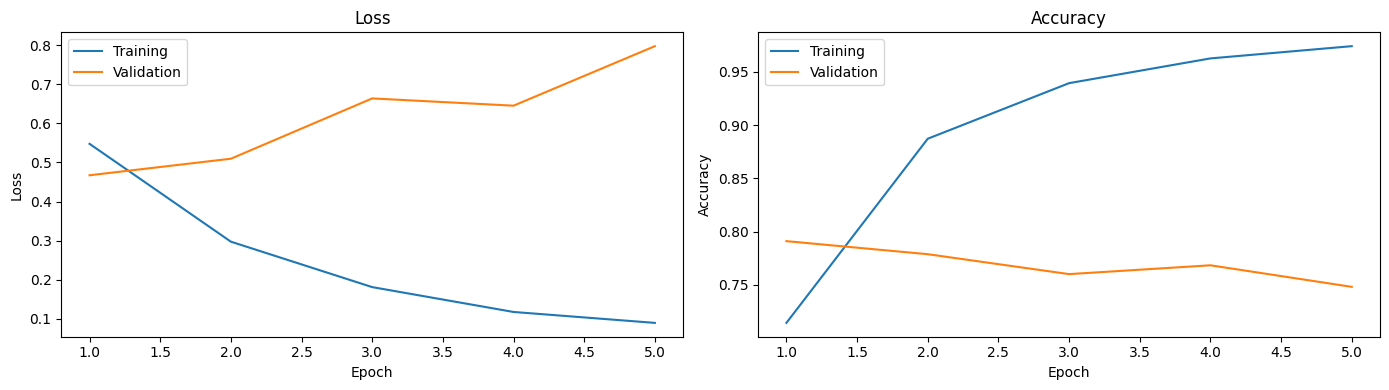

In [14]:
hist_gru = model_gru.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

hist_gru = hist_gru.history
epoch_range = range(1, len(hist_gru['loss']) + 1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, hist_gru['loss'], label='Training')
plt.plot(epoch_range, hist_gru['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, hist_gru['accuracy'], label='Training')
plt.plot(epoch_range, hist_gru['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
y_pred = tf.round(tf.squeeze(model_gru.predict(x_test)))
y_pred = tf.cast(y_pred, tf.int64)


print("Confusion Matrix:", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Precision Score:", precision_score(y_test, y_pred))
print("Recall Score:",recall_score(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred))

102/102 [==============================] - 3s 22ms/step
Confusion Matrix: [[1447  423]
 [ 399  994]]
Accuracy Score: 0.7480845847379712
Precision Score: 0.7014820042342979
Recall Score: 0.7135678391959799
F1 Score: 0.7074733096085409


In [16]:
print(y_pred)

tf.Tensor([1 0 0 ... 0 0 0], shape=(3263,), dtype=int64)


In [17]:
sample_sub = pd.read_csv('nlp-getting-started/sample_submission.csv')
final_sub = pd.DataFrame({'id': sample_sub['id'], 'target': y_pred})
final_sub.to_csv('NLP_model.csv', index=False)

#### Create a LTSM model to compare between the previous NB model

In [18]:
inputs = layers.Input([1,], dtype=tf.string)

x = text_vectorizer(inputs)
x = text_embedding(x)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128)(x)
x = layers.Dense(64, activation='relu')(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model_ltsm = tf.keras.Model(inputs, outputs)
model_ltsm.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
    )

model_ltsm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm_1 (LSTM)               (None, 15, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                           

Epoch 1/5
136/136 [==============================] - 21s 132ms/step - loss: 0.1521 - accuracy: 0.9554 - val_loss: 0.8555 - val_accuracy: 0.7392
Epoch 2/5
136/136 [==============================] - 17s 127ms/step - loss: 0.0694 - accuracy: 0.9754 - val_loss: 1.1782 - val_accuracy: 0.7315
Epoch 3/5
136/136 [==============================] - 20s 147ms/step - loss: 0.0454 - accuracy: 0.9805 - val_loss: 1.2934 - val_accuracy: 0.7444
Epoch 4/5
136/136 [==============================] - 17s 125ms/step - loss: 0.0356 - accuracy: 0.9839 - val_loss: 1.5939 - val_accuracy: 0.7423
Epoch 5/5
136/136 [==============================] - 19s 143ms/step - loss: 0.0329 - accuracy: 0.9853 - val_loss: 1.1924 - val_accuracy: 0.7481


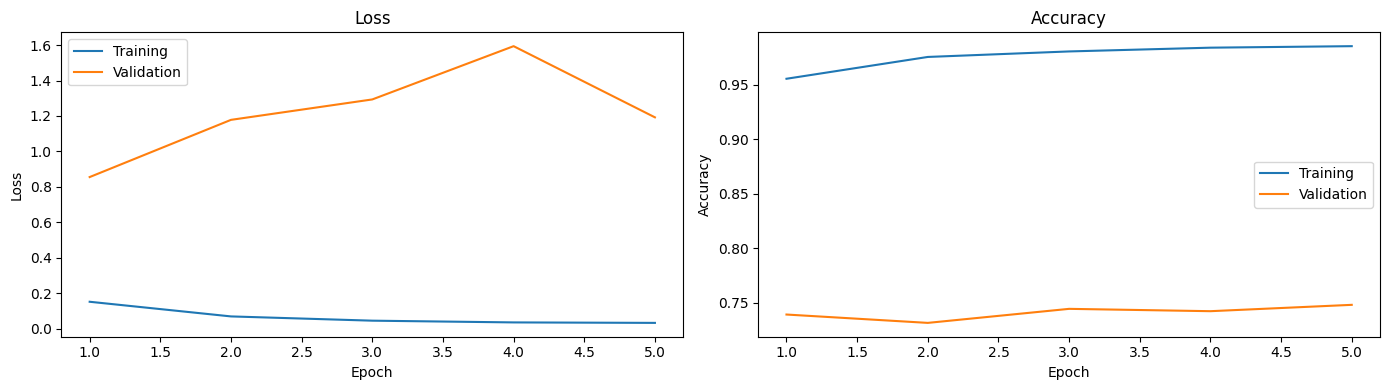

In [19]:
hist_ltsm = model_ltsm.fit(x_train, y_train, epochs=5, validation_data = (x_test, y_test))

hist_ltsm = hist_ltsm.history

epoch_range = range(1, len(hist_ltsm['loss']) + 1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, hist_ltsm['loss'], label='Training')
plt.plot(epoch_range, hist_ltsm['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, hist_ltsm['accuracy'], label='Training')
plt.plot(epoch_range, hist_ltsm['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
y_pred = tf.round(tf.squeeze(model_ltsm.predict(x_test)))

print("Confusion Matrix:", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Precision Score:", precision_score(y_test, y_pred))
print("Recall Score:",recall_score(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred))

102/102 [==============================] - 5s 41ms/step
Confusion Matrix: [[1484  386]
 [ 436  957]]
Accuracy Score: 0.7480845847379712
Precision Score: 0.7125837676842889
Recall Score: 0.6870064608758076
F1 Score: 0.6995614035087719


#### Based on the acuracy score we are moderately ok, it could be closer with further training and condensing. We would select the previous NB model that edges out the LTSM model.

##### references:
##### https://www.kaggle.com/code/akankshasolanki123/nlp-withdisastertweets
##### https://www.kaggle.com/code/aaryanduggal/fork-of-disaster-tweets-w-pyt-rch
##### https://www.kaggle.com/code/saanvi004/tweetanalysis-tf-idf-and-naive 